In [1]:
%matplotlib notebook
%matplotlib inline
%load_ext dotenv
%dotenv

# Dancing Steps Prediction

Background music is the basis of many Western dances. And dancers are following this background music when changing their dancing steps. Most western music has a constant rhythm. Also in sometimes songs using the same rhythm as other songs. Therefore, there is a possibility to use the dance steps of other songs in another song.

## Filtering dance steps from videos

As an example for this chapter I choosed [this](https://www.youtube.com/watch?v=bHqMKm39bAA) video. The input video must be a quality and unmoving video. Otherwise we can not calculate 3d angles in next steps. First I am parsing my video to the program.

In [10]:
import moviepy.editor

videofile = 'right.mp4'

video = moviepy.editor.VideoFileClip(videofile);

Next I am using the openpose to detect coordinates of the dancer's poses. I am running the openpose for only one frame. Otherwise it will take more time. I entered an entry to the `.env` file with the name `OPENPOSE_MODELS_DIR`.



t:   0%|          | 0/2305 [00:00<?, ?it/s, now=None]

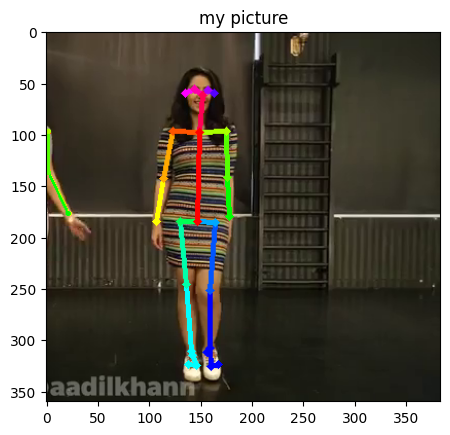

array([[[1.5190346e+02, 6.2033684e+01, 9.2411375e-01],
        [1.4901730e+02, 9.8180382e+01, 8.7376726e-01],
        [1.2261464e+02, 9.7245453e+01, 7.9615730e-01],
        [1.1385577e+02, 1.4313631e+02, 8.8636094e-01],
        [1.0703037e+02, 1.8514044e+02, 8.8443255e-01],
        [1.7541766e+02, 9.7249924e+01, 8.1538916e-01],
        [1.7638644e+02, 1.4217743e+02, 8.0838239e-01],
        [1.7835127e+02, 1.8028650e+02, 6.6042709e-01],
        [1.4706375e+02, 1.8516939e+02, 6.4073968e-01],
        [1.3045287e+02, 1.8514433e+02, 6.2596440e-01],
        [1.3626782e+02, 2.4575703e+02, 8.5167038e-01],
        [1.4116850e+02, 3.1119101e+02, 7.9042220e-01],
        [1.6364673e+02, 1.8611873e+02, 6.2236708e-01],
        [1.5875687e+02, 2.5158748e+02, 8.5181487e-01],
        [1.5879468e+02, 3.0827191e+02, 8.2529324e-01],
        [1.4415816e+02, 5.6206959e+01, 9.3587482e-01],
        [1.5681647e+02, 5.7144012e+01, 9.1372663e-01],
        [1.3533531e+02, 6.0079742e+01, 7.8294462e-01],
        [1

In [9]:
# To detect current pose of the dancer
from openpose import pyopenpose as op
# To retrieve environment variables
import os
# To convert image color format
import cv2
# To display image as a figure
from matplotlib import pyplot as plt

# Initializing the openpose
params = dict();
params["model_folder"] = os.environ.get("OPENPOSE_MODELS_DIR")

opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

datum = op.Datum()

# Cutting intro part of the video
subvideo = video.subclip(3.7);

# Looping over frames in the video
for (t,f) in subvideo.iter_frames(with_times=True, logger="bar"):
    # Converting color format from RGB to BGR(opencv standard format)
    fcv = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
    # Detecting the pose of the dancer
    datum.cvInputData = fcv
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))
    # Rendering the image to test openpose
    rgb = cv2.cvtColor(datum.cvOutputData, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.title('my picture')
    plt.show()
    # Only detecting the pose for first frame
    # Because this iteration is a more time consuming
    # process. So Skipping other frames only to speed up
    # the testing process
    break
datum.poseKeypoints

But I can not use these coordinates to predict dance steps. Because each persons have various body sizes. So these coordinates will defer from person to person. But the angle of joints is independant from person to person. So I have to calculate angles of each joint from these coordinates.

### 2D angels vs 3D angles

The main advantage of using 3D angles is later I can use the same angles to render 3d models. Otherwise I have to draw some 2d animations by using 2d angles.

### Calculating 3D angles

There are three requirements to calculate 3D angles from 2D coordinates.

1. A Timestamp of a frame showing the front perspective of each bone of the dancer
2. Other timestamps of frames that showing front perspective of each bone. It is required to calculate the zoom level of the camera if it is zooming. Example:- (12.00, Neck), (150.00, Leg), (312.00, Hand)
3. An image pattern that exist in each frame in the video. It is required to track movement of the camera if it is moving.

If the video could not satisfy above requirements I have to calculate 2D angels as a fallback.

#### Calculating zoom level


|Normal | Zoom In  |
|:---: | :---: |
|<img src="./resources/zoomcalculate3.svg" alt="Figure 1" width="260"/>|<img src="./resources/zoomcalculate4.svg" alt="Figure 1" width="260"/>|
|<img src="./resources/zoomcalculate1.svg" alt="Figure 1" width="260"/>|<img src="./resources/zoomcalculate2.svg" alt="Figure 1" width="260"/>|


In [49]:
%%latex
\begin{aligned}

\text{Consider } \bigtriangleup \mathbf{FGL} \\
\tan(\angle \mathbf{FLG}) & = { \mathbf{FG} \over{ \mathbf{GL} } } \\
& = { \mathbf{f} \over{\mathbf{b}} } \\
\\
\text{Consider } \bigtriangleup \mathbf{RSX} \\
\tan(\angle \mathbf{RXS}) & = { \mathbf{RS} \over{ \mathbf{SX} } } \\
& = { \mathbf{d} \over{\mathbf{a}} } \\
\\
\angle \mathbf{FLG} &= \angle \mathbf{RXS} \\
\therefore \tan(\angle \mathbf{FLG}) &= \tan( \angle \mathbf{RXS}) \\
{\mathbf{f} \over{\mathbf{b}} } &= {\mathbf{d} \over{\mathbf{a}} }
\end{aligned}

\begin{equation}
\mathbf{a} = {\mathbf{db} \over{\mathbf{f}}} \tag{1} \label{eq:flg_rxs_a}
\end{equation}

\begin{align}
\bigtriangleup \mathbf{AJK} \text{ and } \bigtriangleup \mathbf{MVW} \text{ are coincident }
\end{align}


<IPython.core.display.Latex object>

![AJK and MVW traingles in the same canvas](./resources/zoomcalculate5.svg)

In [47]:
%%latex

\begin{aligned}
A_{\mathbf{DJKE}} & = {{1\over{2}} \times \mathbf{b} \times ( \mathbf{JK} + \mathbf{DE} ) } \\
& = {{1\over{2}} \mathbf{b} ( \mathbf{e} + \mathbf{h} ) } \\

\end{aligned}

\begin{equation}
A_{\mathbf{DJKE}} = {{1\over{2}} \mathbf{b} ( \mathbf{e} + \mathbf{h} ) } \tag{2.1} \label{eq:djke_area}
\end{equation}

\begin{aligned}
A_{\mathbf{DJKE}} & = {{1\over{2}} \times \mathbf{a} \times ( \mathbf{JK} + \mathbf{PQ} ) + {1\over{2}} \times (\mathbf{b} - \mathbf{a}) \times ( \mathbf{PQ} + \mathbf{DE} ) } \\
& = {{1\over{2}} \mathbf{a} ( \mathbf{c} + \mathbf{h} ) + {1\over{2}} (\mathbf{b} - \mathbf{a}) ( \mathbf{c} + \mathbf{e} ) }
\end{aligned}

\begin{equation}
A_{\mathbf{DJKE}} = {{1\over{2}} \mathbf{a} ( \mathbf{c} + \mathbf{h} ) + {1\over{2}} (\mathbf{b} - \mathbf{a}) ( \mathbf{c} + \mathbf{e} ) } \tag{2.2} \label{eq:dpqe_djkq_area}
\end{equation}

\eqref{eq:djke_area} = \eqref{eq:dpqe_djkq_area}

\begin{aligned}
{{1\over{2}} \mathbf{b} ( \mathbf{e} + \mathbf{h} ) } &= {{1\over{2}} \mathbf{a} ( \mathbf{c} + \mathbf{h} ) + {1\over{2}} (\mathbf{b} - \mathbf{a}) ( \mathbf{c} + \mathbf{e} ) } \\
{ \mathbf{b} ( \mathbf{e} + \mathbf{h} ) } &= {\mathbf{a} ( \mathbf{c} + \mathbf{h} ) + (\mathbf{b} - \mathbf{a}) ( \mathbf{c} + \mathbf{e} ) } \\
\mathbf{be} + \mathbf{bh} &= \mathbf{ac} + \mathbf{ah} + (\mathbf{b} - \mathbf{a}) ( \mathbf{c} + \mathbf{e} ) \\
\mathbf{bh}- \mathbf{ah} &= \mathbf{ac} - \mathbf{be} + (\mathbf{b} - \mathbf{a}) ( \mathbf{c} + \mathbf{e} ) \\
\mathbf{h}(\mathbf{b}- \mathbf{a}) &= \mathbf{ac} - \mathbf{be} + \mathbf{bc} + \mathbf{be} - \mathbf{ac} - \mathbf{ae} \\
&=   \mathbf{bc}  - \mathbf{ae}

\end{aligned}

\begin{equation}
\mathbf{h} = {{\mathbf{bc}  - \mathbf{ae}}\over{\mathbf{b}- \mathbf{a}}} \tag{2} \label{eq:trapzoid_area_h}
\end{equation}


<IPython.core.display.Latex object>

### Future Works

In [12]:
# Processing audio file
import librosa

audiofile = 'tmp/song.wav'
y, sr = librosa.load(audiofile)
sr, y


(22050,
 array([0.        , 0.        , 0.        , ..., 0.54448503, 0.6150214 ,
        0.        ], dtype=float32))

In [14]:

tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
beats_times = librosa.frames_to_time(beats, sr=sr)
tempo, beats_times

(99.38401442307692,
 array([ 0.16253968,  0.74303855,  1.30031746,  1.88081633,  2.43809524,
         2.99537415,  3.57587302,  4.15637188,  4.7600907 ,  5.36380952,
         5.96752834,  6.54802721,  7.15174603,  7.75546485,  8.35918367,
         8.96290249,  9.56662132, 10.14712018, 10.750839  , 11.35455782,
        11.95827664, 12.56199546, 13.16571429, 13.74621315, 14.34993197,
        14.95365079, 15.55736961, 16.13786848, 16.76480726, 17.36852608,
        17.94902494, 18.55274376, 19.13324263, 19.76018141, 20.36390023,
        20.96761905, 21.57133787, 22.15183673, 22.75555556, 23.33605442,
        23.9629932 , 24.56671202, 25.14721088, 25.75092971, 26.35464853,
        26.95836735, 27.56208617, 28.14258503, 28.74630385, 29.35002268,
        29.9537415 , 30.55746032, 31.16117914, 31.76489796, 32.36861678,
        32.94911565, 33.55283447, 34.15655329, 34.76027211, 35.36399093,
        35.96770975, 36.57142857, 37.17514739, 37.75564626, 38.35936508,
        38.9630839 , 39.5668027

In [25]:
# Iterate over frames
from IPython.display import display, HTML

pt = 0;
html = "<div >";
for t in beats_times:
    if t>50.00 and t<60:
        sub_clip = video.subclip(pt,t)
        sub_clip.write_gif("tmp/{:f}.gif".format(t))
        html = html + """<figure style='display:inlint'>
                <img style='height:80px' alt='{:f}' src='tmp/{:f}.gif' />
                <figcaption>After {:f}</figcaption>
            </figure>""".format(t,t,t)
    pt = t
html = html + '</div>'
HTML(html)

t:  16%|█▌        | 3/19 [00:00<00:00, 24.32it/s, now=None]

MoviePy - Building file tmp/50.364082.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 25.13it/s, now=None] 

MoviePy - Building file tmp/50.967800.gif with imageio.


t:  17%|█▋        | 3/18 [00:00<00:00, 24.73it/s, now=None] 

MoviePy - Building file tmp/51.548299.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 26.79it/s, now=None] 

MoviePy - Building file tmp/52.152018.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 23.56it/s, now=None] 

MoviePy - Building file tmp/52.755737.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 25.57it/s, now=None] 

MoviePy - Building file tmp/53.359456.gif with imageio.


t:  17%|█▋        | 3/18 [00:00<00:00, 25.42it/s, now=None] 

MoviePy - Building file tmp/53.939955.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 24.35it/s, now=None] 

MoviePy - Building file tmp/54.543673.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 25.07it/s, now=None] 

MoviePy - Building file tmp/55.147392.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 24.55it/s, now=None] 

MoviePy - Building file tmp/55.751111.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 23.83it/s, now=None] 

MoviePy - Building file tmp/56.354830.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 24.31it/s, now=None] 

MoviePy - Building file tmp/56.958549.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 25.07it/s, now=None] 

MoviePy - Building file tmp/57.562268.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 26.02it/s, now=None] 

MoviePy - Building file tmp/58.165986.gif with imageio.


t:  17%|█▋        | 3/18 [00:00<00:00, 26.42it/s, now=None] 

MoviePy - Building file tmp/58.746485.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 25.50it/s, now=None] 

MoviePy - Building file tmp/59.350204.gif with imageio.


t:  16%|█▌        | 3/19 [00:00<00:00, 24.33it/s, now=None] 

MoviePy - Building file tmp/59.953923.gif with imageio.
